In [1]:
# 🟦 Installation and nanoGPT setup
!git clone https://github.com/karpathy/nanoGPT.git
%cd nanoGPT
!pip install torch numpy tqdm

Cloning into 'nanoGPT'...
remote: Enumerating objects: 686, done.
remote: Total 686 (delta 0), reused 0 (delta 0), pack-reused 686 (from 1)
Receiving objects: 100% (686/686), 954.04 KiB | 7.40 MiB/s, done.
Resolving deltas: 100% (387/387), done.
/kaggle/working/nanoGPT
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvji

In [2]:
# 🔧 Standard libraries
import os
import math
import random
import pickle
import re
from collections import Counter

# 🔢 Numerical computing
import numpy as np
import pandas as pd

# 📈 Visualization
import matplotlib.pyplot as plt

# 🧠 Machine learning
import torch
from model import GPTConfig, GPT

In [3]:
input_file = "/kaggle/input/voynich/CD2a-n.txt"
output_file = "/kaggle/working/voynich_final.txt"  # Cleaned file for training in Colab

# 1. Filter valid lines in memory
filtered_lines = []
with open(input_file, "r", encoding="utf-8") as f_in:
    for line in f_in:
        line = line.strip()
        if line.startswith("#"):
            continue
        if line.startswith("<") and ">" in line:
            header = line.split(">")[0][1:]
            if "." not in header:
                continue
        filtered_lines.append(line)

# 2. Remove <...> headers and keep only transliterated text
clean_lines = []
for line in filtered_lines:
    if line.startswith("<") and ">" in line:
        parts = line.split(">", 1)
        if len(parts) == 2:
            clean_lines.append(parts[1].strip())

# 3. Group paragraphs in memory
paragraph_lines = []
active = False
buffer = []

for line in clean_lines:
    line = line.strip()
    line = line.replace("<->", ".").replace("<~>", ".").replace(" ", ".")

    if line.startswith("<%>") and line.endswith("<$>"):
        paragraph_lines.append(line.replace("<%>", "").replace("<$>", "").strip())
    elif line.startswith("<%>"):
        active = True
        buffer.append(line.replace("<%>", "").strip())
    elif active:
        if "<$>" in line:
            buffer.append(line.replace("<$>", "").strip())
            paragraph_lines.append(" ".join(buffer))
            buffer = []
            active = False
        else:
            buffer.append(line)
    else:
        paragraph_lines.append(line)

# 4. Filter out lines with '?' and empty lines, then write to final output file
with open(output_file, "w", encoding="utf-8") as f_out:
    for line in paragraph_lines:
        if line and "?" not in line:
            f_out.write(line + "\n")

print(f"✅ Final file saved at: {output_file}")

✅ Final file saved at: /kaggle/working/voynich_final.txt


In [4]:
def remove_words_with_question_mark(text):
    cleaned_lines = []
    for line in text.splitlines():
        words = line.split(".")  # split by dots
        cleaned_words = [word for word in words if "?" not in word]
        cleaned_line = ".".join(cleaned_words)
        # If the original line ended with a dot, preserve it
        if line.endswith(".") and not cleaned_line.endswith("."):
            cleaned_line += "."
        cleaned_lines.append(cleaned_line)
    return "\n".join(cleaned_lines)

clean_text = []

for line in paragraph_lines:
    clean_text.append(remove_words_with_question_mark(line))

with open("/kaggle/working/paragrafs_lines_cleaned.txt", "w", encoding="utf-8") as f_out:
    for line in clean_text:
        f_out.write(line + "\n")

In [5]:
# 📄 Comment out the line that breaks training on GPUs like T4 (Google Colab, Kaggle, etc.)
train_script_path = "train.py"

# Modify train.py to comment out the line with torch.compile(model)
if os.path.exists(train_script_path):
    with open(train_script_path, "r") as file:
        lines = file.readlines()

    with open(train_script_path, "w") as file:
        for line in lines:
            if "torch.compile(model)" in line:
                file.write("# " + line)  # Comment out the problematic line
            else:
                file.write(line)
else:
    print(f"⚠️ File {train_script_path} not found in {os.getcwd()}")

# 🧾 Join all text paragraphs into a single string
# Note: each line is a paragraph with words separated by dots (.)
# Since we want character-level training, we join lines using newlines to mark paragraph breaks
raw_text = "\n".join(clean_text)

# 🔤 Tokenize by character
char_tokens = list(raw_text)
print(f"{len(char_tokens)} characters identified.")

# 🔤 Tokenize by "word" (dot-separated)
tokens = [w for w in raw_text.split('.') if w.strip()]
print(f"{len(tokens)} words identified.")

# 🧠 Build character-level vocabulary
vocab = sorted(set(char_tokens))
char_to_idx = {ch: i for i, ch in enumerate(vocab)}
idx_to_char = {i: ch for ch, i in char_to_idx.items()}
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

82062 characters identified.
13917 words identified.
Vocabulary size: 38


In [6]:
# 🔁 Encode characters as integer IDs
encoded_data = [char_to_idx[ch] for ch in char_tokens]

# ✂️ Train/validation split
split_idx = int(0.9 * len(encoded_data))
train_data = encoded_data[:split_idx]
val_data = encoded_data[split_idx:]

# 💾 Save encoded data
os.makedirs("data/voynich", exist_ok=True)
np.array(train_data, dtype=np.uint16).tofile("data/voynich/train.bin")
np.array(val_data, dtype=np.uint16).tofile("data/voynich/val.bin")

# 🔑 Save vocabulary metadata
meta = {
    "vocab_size": vocab_size,
    "itos": idx_to_char,
    "stoi": char_to_idx,
    "level": "char"
}
with open("data/voynich/meta.pkl", "wb") as f:
    pickle.dump(meta, f)

# ⚙️ Training configuration script
os.makedirs("config", exist_ok=True)
with open("config/train_voynich.py", "w") as f:
    f.write('''
out_dir = 'out-voynich'
eval_interval = 100
eval_iters = 20
log_interval = 1000
always_save_checkpoint = False

block_size = 128
batch_size = 32
n_layer = 4
n_head = 4
n_embd = 128

max_iters = 2500
lr_decay_iters = 100
learning_rate = 1e-3
dropout = 0.1

wandb_log = False
dataset = 'voynich'
gradient_accumulation_steps = 1
bias = False
''')

# 🧩 Save custom dataset class
with open("data/voynich.py", "w") as f:
    f.write('''
import os
import numpy as np
import pickle
import torch
from torch.utils.data import Dataset

class VoynichDataset(Dataset):
    def __init__(self, split):
        data_dir = os.path.join(os.path.dirname(__file__), 'voynich')
        data = np.fromfile(os.path.join(data_dir, f'{split}.bin'), dtype=np.uint16)
        self.data = torch.tensor(data, dtype=torch.long)

        with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
            meta = pickle.load(f)
        self.vocab_size = meta['vocab_size']
        self.stoi = meta['stoi']
        self.itos = meta['itos']
        self.block_size = 128

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.block_size]
        y = self.data[idx + 1:idx + 1 + self.block_size]
        return x, y
''')

# 🚀 Launch training
!python train.py config/train_voynich.py

Overriding config with config/train_voynich.py:

out_dir = 'out-voynich'
eval_interval = 100
eval_iters = 20
log_interval = 1000
always_save_checkpoint = False

block_size = 128
batch_size = 32
n_layer = 4
n_head = 4
n_embd = 128

max_iters = 2500
lr_decay_iters = 100
learning_rate = 1e-3
dropout = 0.1

wandb_log = False
dataset = 'voynich'
gradient_accumulation_steps = 1
bias = False

tokens per iteration will be: 4,096
found vocab_size = 38 (inside data/voynich/meta.pkl)
Initializing a new model from scratch
number of parameters: 0.79M
/kaggle/working/nanoGPT/train.py:196: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))
num decayed parameter tensors: 18, with 807,680 parameters
num non-decayed parameter tensors: 9, with 1,152 parameters
using fused AdamW: True
compiling the model... (takes a ~minute)
step 0: train loss 3.6929, val loss 3.69

In [7]:
# 🧾 Load the trained model
ckpt_path = "out-voynich/ckpt.pt"
checkpoint = torch.load(ckpt_path, map_location='cpu')

# ⚙️ Load model configuration
config = GPTConfig(
    block_size=128,
    vocab_size=checkpoint['model_args']['vocab_size'],
    n_layer=checkpoint['model_args']['n_layer'],
    n_head=checkpoint['model_args']['n_head'],
    n_embd=checkpoint['model_args']['n_embd']
)

model = GPT(config)
model.load_state_dict(checkpoint['model'], strict=False)
model.eval()

# 🧠 Load validation data
val_data = np.fromfile("data/voynich/val.bin", dtype=np.uint16)
val_data = torch.tensor(val_data, dtype=torch.long)

# 🔍 Compute perplexity
block_size = config.block_size
losses = []

with torch.no_grad():
    for i in range(0, len(val_data) - block_size, block_size):
        x = val_data[i:i+block_size].unsqueeze(0)
        y = val_data[i+1:i+1+block_size].unsqueeze(0)
        logits, loss = model(x, y)
        losses.append(loss.item())

avg_loss = np.mean(losses)
perplexity = np.exp(avg_loss)

print(f"📉 Average loss on validation set: {avg_loss:.4f}")
print(f"🤯 Perplexity on validation set: {perplexity:.2f}")

number of parameters: 0.80M
📉 Average loss on validation set: 1.2166
🤯 Perplexity on validation set: 3.38


In [8]:
def generate_text(model, start_text, length=200, temperature=1.0):
    model.eval()
    device = next(model.parameters()).device

    # Encode the prompt into index tokens
    idx = torch.tensor([char_to_idx[ch] for ch in start_text], dtype=torch.long)[None, :].to(device)

    generated = idx

    with torch.no_grad():
        for _ in range(length):
            # If the sequence exceeds block_size, trim it to the last block_size tokens
            input_seq = generated[:, -model.config.block_size:]

            logits, _ = model(input_seq)
            logits = logits[:, -1, :] / temperature
            probs = torch.nn.functional.softmax(logits, dim=-1)
            next_idx = torch.multinomial(probs, num_samples=1)
            generated = torch.cat((generated, next_idx), dim=1)

    generated_text = "".join(idx_to_char[i.item()] for i in generated[0])
    return generated_text

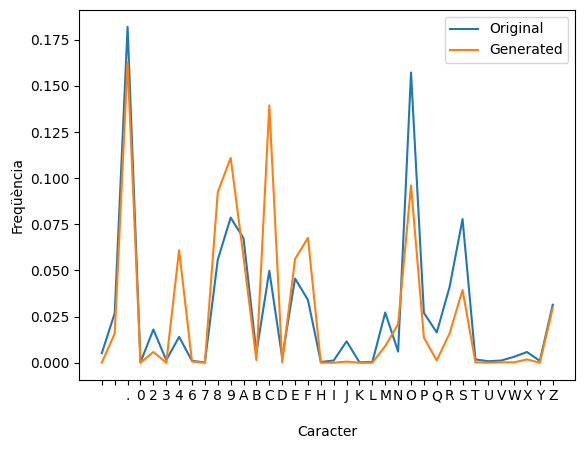

8S9.Z9.FCC89.S89.89.89.SC6.FC89.89.OE.X89 9SCC89.SC89.ZCF9.SCP9.OPC8.9PCC89.SCP9.OPC89.OPC89 PC89.SCCVAR.ZCFC89.OFCZC89.OFC89.FCC89.OFCC89.SC89.8AR.ARAE.OFC89 4OFCC89.4OFCC89.OFCC89.8AR.ZC89.4OFCC89.4OFC89.4OFC89.OFO89.OPC89.OPOEFC89.4OFC89.SCC89.8AE.SCC89.8AJ 9PCC8AR.SC89.4OFC89.89.OPC89.4OFC89.4OFCC89.4OPC89.4OFC89.4OFCC89.4OFAE.8 POE.ZCC89.OFCC89.SC89.4OFAR.SCC89.S89.OFC8OE.SCC9.4OFCC89.ESC89.4OPC89 4OFCC89.4OFC89.4OFC89.SC89.4OFC89.4OFCCOE.SC89.OPCC89.ZC89.ESC89.2AR.OFAJ.SC89 4OFC89.2SC89.4OFC89.4OFC89.ZXC89.9PAE.ZCC89.FC89.FCC89.FAJ FCC89.ZC89.OFCC89.4OFCC89.FC89.2AR.SC89.8AM.OFAE.FC89.FAE89 2AT.SCC89.OFAR.AE.4OFCC9.4OFAR.OR.OFCCCC9.OFANOR.AR.OFAN.SC89.8AE EZC89.4OFCC9.4OFAM.OEFAE.4OF9.OFAN.SC2.OFAN.SCC89.4OFAM.9FAE.OE.89 8OESC89.4OFAE.ROR.ZC89.4OFS89.SFC89.8SC89.OEAR.SC89.4OFAR.OR.AEOR.OE OE.AE.SC89.4OFC89.4OFC89.4OFOE.SC89.4OFAE89.OFASC89.8OE.SC89 8SC89.8AE.8AE.8AR.SCC9.2AR.9FCC89.4OFC89.ORSC89.ZC89.ZC89.OFC89 9ZC89.4OFC89.ZC89.4OE.FC89.4OFAN.ZC89.2OE.9FCC89.4OFCC89.EZC89.4OFCC8

In [9]:
def plot_char_distribution(texts, labels):
    counts = [Counter(text) for text in texts]
    chars = sorted(set("".join(texts)))
    
    for i, count in enumerate(counts):
        freqs = [count[c]/len(texts[i]) for c in chars]
        plt.plot(chars, freqs, label=labels[i])
    
    plt.xlabel("Caracter")
    plt.ylabel("Freqüència")
    plt.legend()
    plt.show()

generated_text = generate_text(model, "8", length=5000, temperature=0.8)
plot_char_distribution([raw_text[:5000], generated_text], ["Original", "Generated"])
print(generated_text)